## Create non IID dataset with different frequencies

Test script, to be integrated in main pipeline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lib.generate_timeseries import Periodic_1d
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import seaborn as sns
import sys
import json
import glob

import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
# Ensure seaborn theme
sns.set(style='whitegrid')
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from plot_utils import read_loss_file

In [3]:
####################################
# Data generation
#####################################

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "freq_amp_decay2"

max_freq = 3.0
step_freq = 0.2

n_clients = 2
n_samples_per_client = 200  # number of samples per client

# fixed for now
amp = 1.0
noise_weight = 0
n_total_tp = None
max_t_extrap = None

time_steps = sample_timesteps(n_total_tp= 100, max_t_extrap = 5)

freq_0 = 0.1
freq_1 = 0.1

# sample a number between 0 and 10


while freq_1 <= max_freq:
    print(f"Generating dataset for frequency {freq_0} and {freq_1}...")
    amp1 = amp * np.random.uniform(0, 10)  
    # Generate data for first client
    dataset, timesteps = get_dataset([amp, amp*np.random.uniform(0, 10)], [freq_0, freq_0*np.random.uniform(0, 10)], time_steps, noise_weight=noise_weight, n_samples=n_samples_per_client)
    amps = np.full((dataset.shape[0],), amp)
    freqs = np.full((dataset.shape[0],), freq_0)
    full_dataset = amps, freqs, dataset, timesteps
    train, test = split_train_test_with_meta(full_dataset, train_fraq = 0.8)
    dataset_prefix = f"{prefix}_maxfreq_{freq_1}"
    store_dataset(train, test, dataset_prefix=dataset_prefix, path_prefix=path_prefix, client_prefix=f"client_0")

    # Generate data for second client
    dataset, timesteps = get_dataset([amp1, amp1*np.random.uniform(0, 10)], [freq_1, freq_1*np.random.uniform(0, 10)], time_steps, noise_weight=noise_weight, n_samples=n_samples_per_client)
    amps = np.full((dataset.shape[0],), amp)
    freqs = np.full((dataset.shape[0],), freq_1)
    full_dataset = amps, freqs, dataset, timesteps
    train, test = split_train_test_with_meta(full_dataset, train_fraq = 0.8)
    dataset_prefix = f"{prefix}_maxfreq_{freq_1}"
    store_dataset(train, test, dataset_prefix=dataset_prefix, path_prefix=path_prefix, client_prefix=f"client_1")

    freq_1 += step_freq
    # keep it to one decimal place
    freq_1 = round(freq_1, 2)
print("Dataset generation completed.")

Generating dataset for frequency 0.1 and 0.1...
Generating dataset for frequency 0.1 and 0.3...
Generating dataset for frequency 0.1 and 0.5...
Generating dataset for frequency 0.1 and 0.7...
Generating dataset for frequency 0.1 and 0.9...
Generating dataset for frequency 0.1 and 1.1...
Generating dataset for frequency 0.1 and 1.3...
Generating dataset for frequency 0.1 and 1.5...
Generating dataset for frequency 0.1 and 1.7...
Generating dataset for frequency 0.1 and 1.9...
Generating dataset for frequency 0.1 and 2.1...
Generating dataset for frequency 0.1 and 2.3...
Generating dataset for frequency 0.1 and 2.5...
Generating dataset for frequency 0.1 and 2.7...
Generating dataset for frequency 0.1 and 2.9...
Dataset generation completed.


In [4]:
dataset_prefix = f"freq_amp_decay2*"
data_folder = "../data/"
data_files = glob.glob(os.path.join(data_folder, f"{dataset_prefix}*/client_0_train.pt"))
data_files

['../data/freq_amp_decay2_maxfreq_0.1/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_2.3/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_2.5/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_2.1/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_2.9/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_1.1/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_0.5/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_1.5/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_1.7/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_0.7/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_0.9/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_1.3/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_2.7/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_1.9/client_0_train.pt',
 '../data/freq_amp_decay2_maxfreq_0.3/client_0_train.pt']

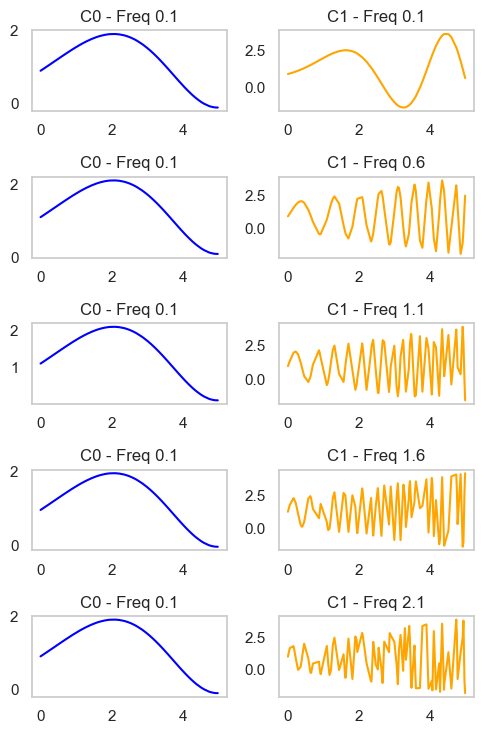

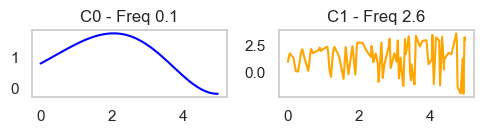

In [36]:
dataset_prefix = f"freq_amp_decay*"
data_folder = "../data/"
data_files = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_0_train.pt"))
data_files.sort(key=lambda x: float(x.split("maxfreq_")[-1].split("_")[0].split("/")[0]))

rows_per_fig = 5

c0_freq = None
for batch_start in range(0, len(data_files), rows_per_fig):
    batch = data_files[batch_start:batch_start + rows_per_fig]
    fig, axes = plt.subplots(nrows=len(batch), ncols=2, figsize=(5, 1.5 * len(batch)), squeeze=False)

    for i, file in enumerate(batch):
        max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
        #print(f"Loading data from {file} with max frequency {max_freq}...")
        if c0_freq is None:
            c0_freq = max_freq

        y0 = torch.load(file, weights_only=True)[0].squeeze()
        x0 = torch.load(file.replace("train", "time_steps_train"), weights_only=True)[0].squeeze()

        client_1_file = file.replace("client_0", "client_1")
        y1 = torch.load(client_1_file, weights_only=True)[0].squeeze()
        x1 = torch.load(client_1_file.replace("train", "time_steps_train"), weights_only=True)[0].squeeze()

        # Client 0 plot
        ax0 = axes[i][0]
        ax0.plot(x0, y0, color='blue')
        ax0.set_title(f"C0 - Freq {c0_freq}")
        ax0.grid()

        # Client 1 plot
        ax1 = axes[i][1]
        ax1.plot(x1, y1, color='orange')
        ax1.set_title(f"C1 - Freq {max_freq}")
        ax1.grid()

    plt.tight_layout()
    plt.show()

## Plot the results

In [92]:
result_json = glob.glob(f"../results_freq_noise/*maxfreq*/federated_training/**/100_rounds/**/results.json", recursive=True)
len(result_json)

171

In [93]:


start_freq = 0.1
df_summary_centralized = pd.DataFrame()
df_summary_federated = pd.DataFrame()
df_summary_aggregation = pd.DataFrame()
for file in result_json:
    # max frequency is encoded in the filename
    max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
    difference = max_freq - start_freq
    df_centralized_evaluate, df_federated_evaluate, df_aggregation = read_loss_file(file)
    df_centralized_evaluate['max_freq'] = max_freq
    df_centralized_evaluate['difference'] = difference
    df_summary_centralized = pd.concat([df_summary_centralized, df_centralized_evaluate], ignore_index=True)
    df_federated_evaluate['max_freq'] = max_freq
    df_federated_evaluate['difference'] = difference
    df_summary_federated = pd.concat([df_summary_federated, df_federated_evaluate], ignore_index=True)
    df_aggregation['max_freq'] = max_freq
    df_aggregation['difference'] = difference
    df_summary_aggregation = pd.concat([df_summary_aggregation, df_aggregation], ignore_index=True)
    #print(f"Processing results for max frequency {max_freq} with difference {difference}...")




In [102]:

# find the min loss for each difference, aggreagation, type 
df_summary_centralized['min_loss'] = df_summary_centralized.groupby(['difference', 'aggregation', 'type'])['loss'].transform('min')

# per difference, aggregation, type get the convergence_round, which is the min round where the loss is within 1/10 of the min loss
df_summary_centralized['convergence_round'] = df_summary_centralized.groupby(['difference', 'aggregation', 'type'])['round'].transform(
    lambda x: x[df_summary_centralized['loss'] <= df_summary_centralized['min_loss'] * 1.2].min()
)





<Figure size 1000x300 with 0 Axes>

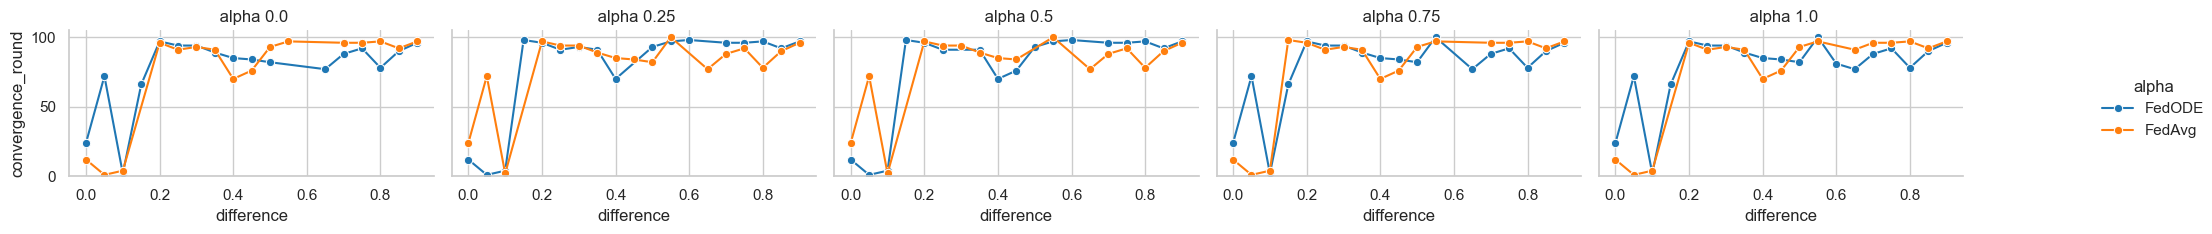

In [103]:
######################################
#  Plot the last loss vs difference
#######################################
df_summary_centralized_last = df_summary_centralized[df_summary_centralized["round"] == max(df_summary_centralized["round"])]
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_centralized_last,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='convergence_round',
    hue='aggregation',
    palette='tab10',
    marker ='o'
)

# Adjustments
g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))



# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()


In [104]:
######################################
#  Plot the lambdas vs difference
#######################################

# fed ode results, keep files that contain "FedODE" in the path name
results_fed_ode = [file for file in result_json if "FedODE" in file]

df_summary = pd.DataFrame()
for file in results_fed_ode:
    #print(f"Processing file {file}...")
    # maxfreq find anything with maxfreq_ in the filename and extract what is after the _
    max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
    #print(f"Max frequency: {max_freq}")
    difference = max_freq - start_freq
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    # merge by round
    df_summary_temp = pd.concat([df_centralized_evaluate_temp, df_federated_evaluate_temp])
    # merge df aggregation by round
    df_aggregation_temp['round'] = df_aggregation_temp['round'].astype(int)
    df_summary_temp = df_summary_temp.merge(df_aggregation_temp, on=['round', 'alpha'], how='left')
    df_summary_temp['max_freq'] = max_freq
    df_summary_temp['difference'] = difference
    df_summary = pd.concat([df_summary, df_summary_temp])

    # add df_aggregation to df_summary
# remove round 0 

# from df summary print x the rounds and y the lambdas 
df_summary['round'] = df_summary['round'].astype(int)
df_summary = df_summary[df_summary['round'] > 0]  # filter out round 0
# explode lambdas 
# lambdas contains a vector 
# take out the 2 lambdas and put them in a new column called lambda and a new column called client and containig 0 or 1\
df_summary['lambda_0'] = df_summary['lambdas'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_summary['lambda_1'] = df_summary['lambdas'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
df0 = df_summary[['round', 'difference', 'lambda_0', 'aggregation', 'alpha']].copy()
df0['client'] = 0
df0 = df0.rename(columns={'lambda_0': 'lambda'})
df1 = df_summary[['round', 'difference', 'lambda_1', 'aggregation', 'alpha']].copy()
df1.rename(columns={'lambda_1': 'lambda'}, inplace=True)
df1['client'] = 1
df_summary_lambdas = pd.concat([df0, df1], ignore_index=True)
df_summary_lambdas_last = df_summary_lambdas[df_summary_lambdas["round"] == max(df_summary_lambdas["round"])]


<Figure size 1000x300 with 0 Axes>

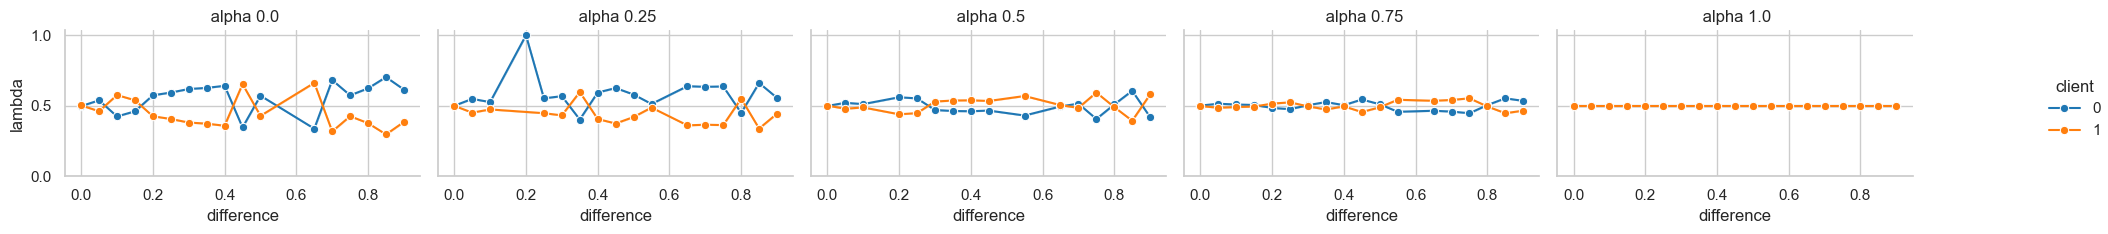

In [105]:

# ensure round is int
# plot
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas_last,
    col="alpha",
    row = "round",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True,
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='lambda',
    hue="client",
    palette='tab10',
    marker='o'
)

# Adjustments
g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))

# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()